# **Predicting emissions using the _ARIMA_ model**

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

**Importing timeseries**

In [1]:
from aggregate import *

In [2]:
ts_dict = {'admin': ts_admin, 'centre_com': ts_centre_com, 'occup_cont': ts_occup_cont, 'autre': ts_autre}

**Plotting timeseries**

In [3]:
def show_trends(dict):
    fig, axs = plt.subplots(2, 2, figsize=(14, 8))

    for (i, j), key in zip([(0, 0), (0, 1), (1, 0), (1, 1)], dict.keys()):
        axs[i, j].plot(dict[key])
        axs[i, j].set_title(key)
        axs[i, j].set_ylabel('emission_ges')

    fig.suptitle(r'CO$_2$ emissions by category')
    plt.tight_layout()
    plt.show()

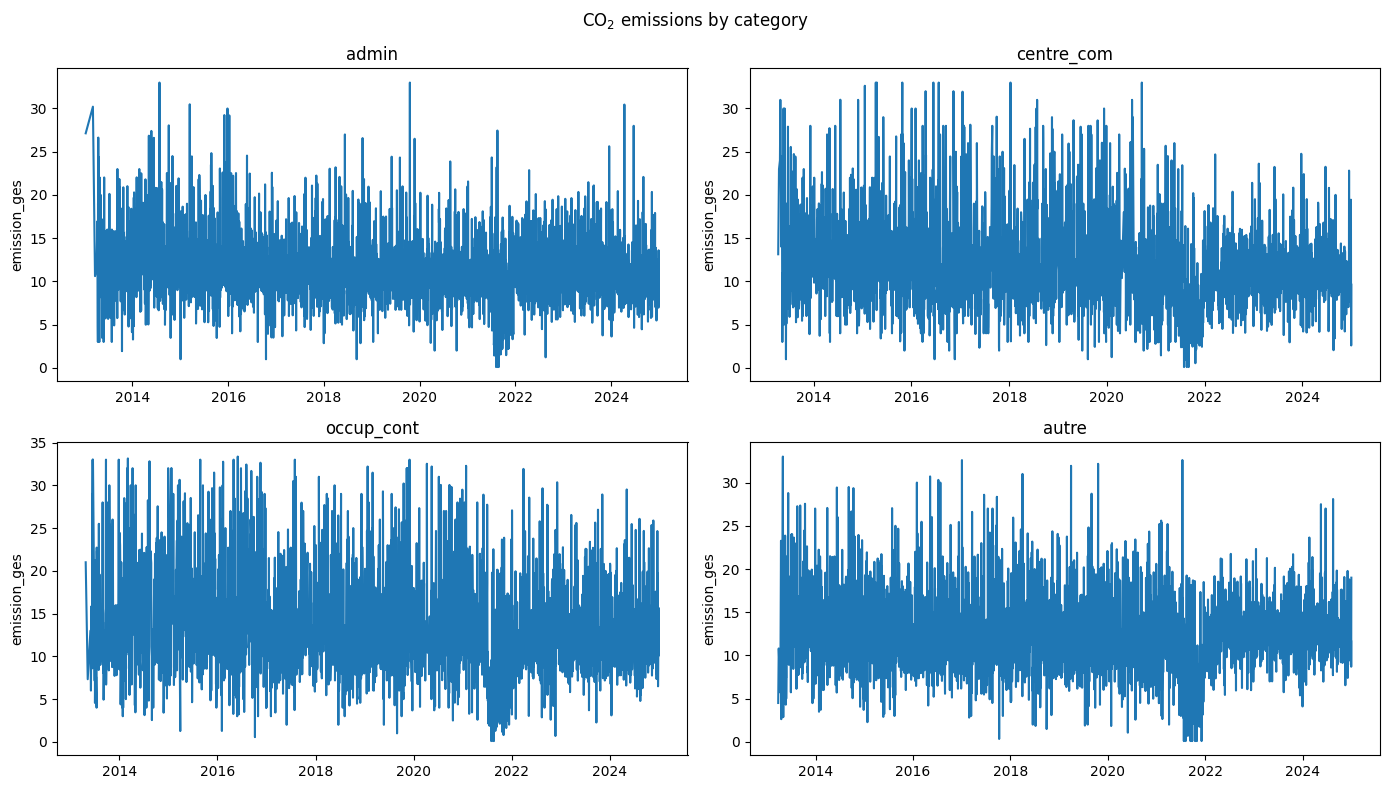

In [6]:
show_trends(ts_dict)

**Plotting differentiated timeseries**

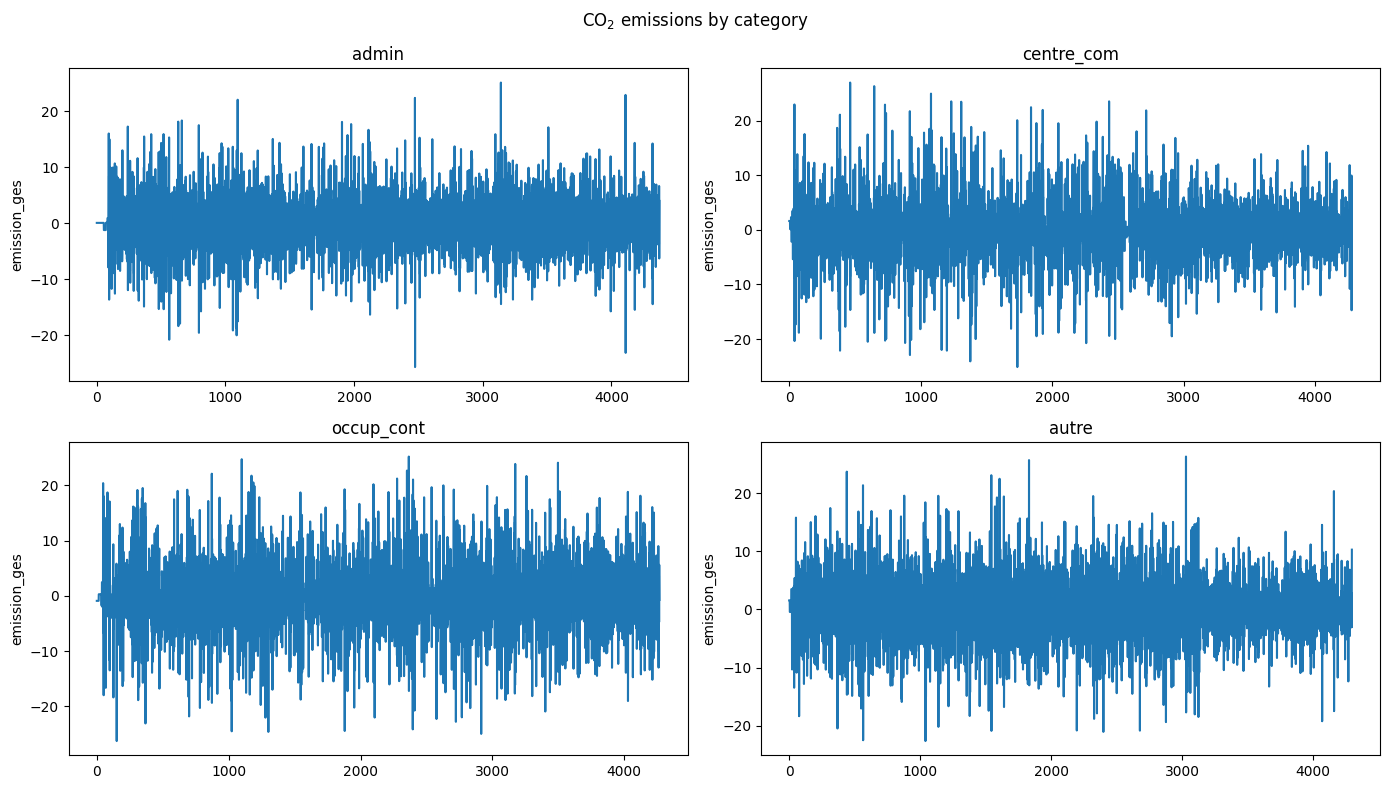

In [7]:
ts_diff_dict = dict(zip(ts_dict.keys(), list(map(np.diff, ts_dict.values()))))
show_trends(ts_diff_dict)

**Stationarity testing via the _Dickey-Fuller_ test**

In [8]:
for key, ts in ts_diff_dict.items():
    adf_result = adfuller(ts)
    print(f'----------------------------\n--> Column: §§ {key} §§')
    print(f'ADF Statistic:  {adf_result[0]}')
    print(f'p-value:  {adf_result[1]}')

----------------------------
--> Column: §§ admin §§
ADF Statistic:  -19.13438188189453
p-value:  0.0
----------------------------
--> Column: §§ centre_com §§
ADF Statistic:  -19.547223453876786
p-value:  0.0
----------------------------
--> Column: §§ occup_cont §§
ADF Statistic:  -19.339629432351696
p-value:  0.0
----------------------------
--> Column: §§ autre §§
ADF Statistic:  -20.162891953859138
p-value:  0.0


**Parameter estimation using the ACF and PCF**

In [9]:
def acf_pcf(ts, key:str):
    plt.figure(figsize=(12, 5))
    plt.subplot(121)
    plot_acf(ts, ax=plt.gca(), lags=40)
    plt.title(f'ACF of Differenced Series: {key}')
    plt.subplot(122)
    plot_pacf(ts, ax=plt.gca(), lags=40)
    plt.title(f'PACF of Differenced Series: {key}')
    plt.tight_layout()
    plt.show()

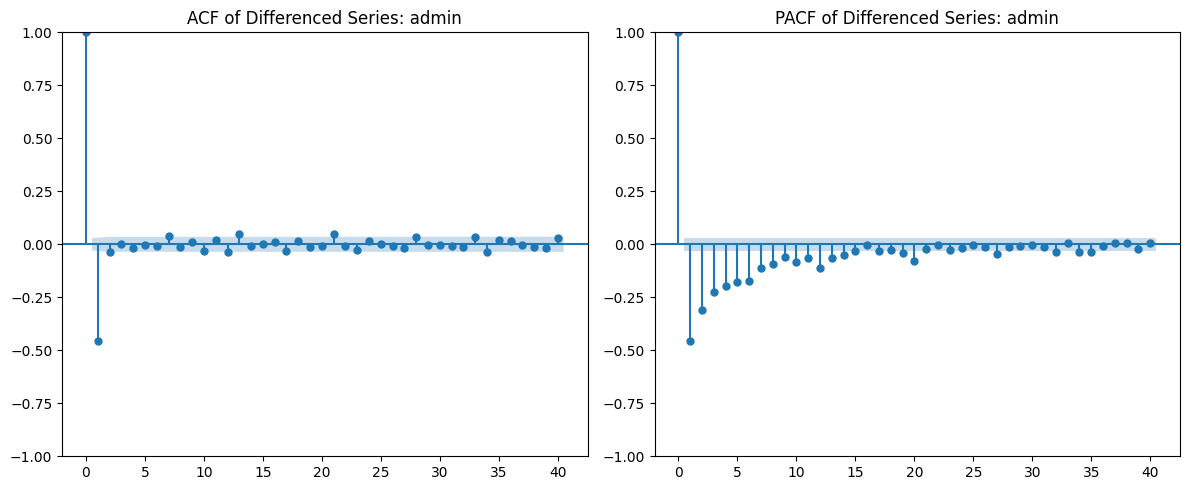

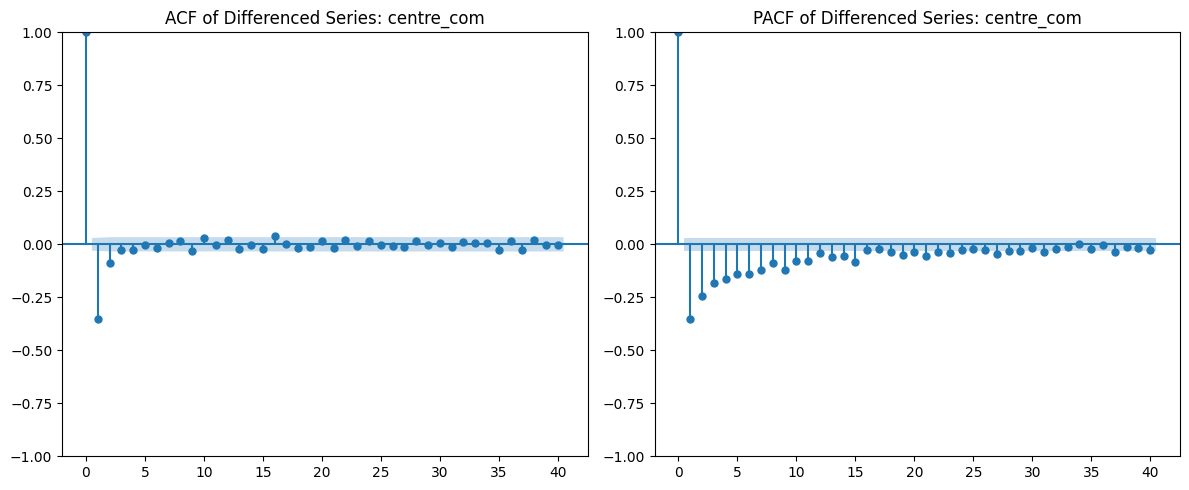

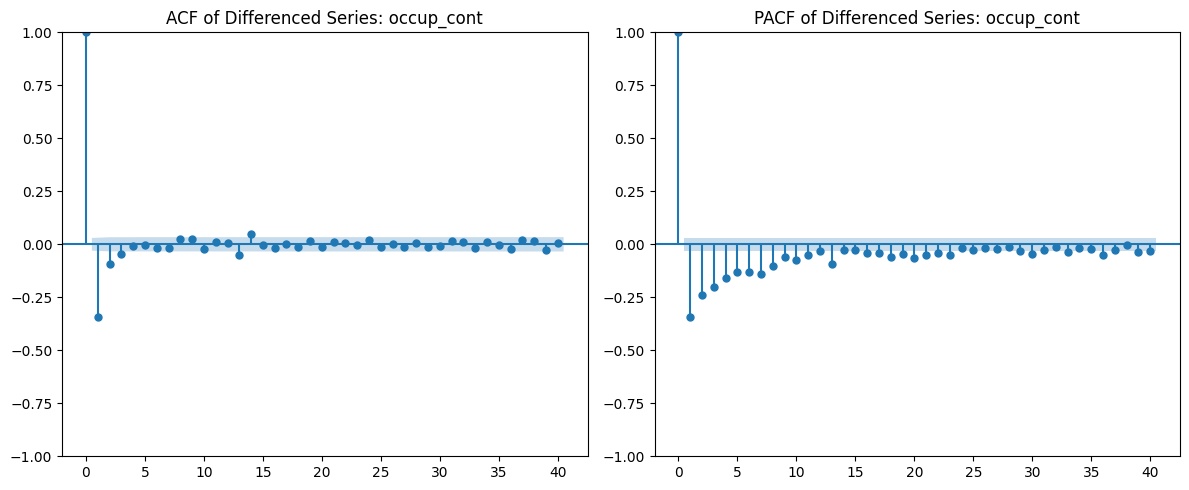

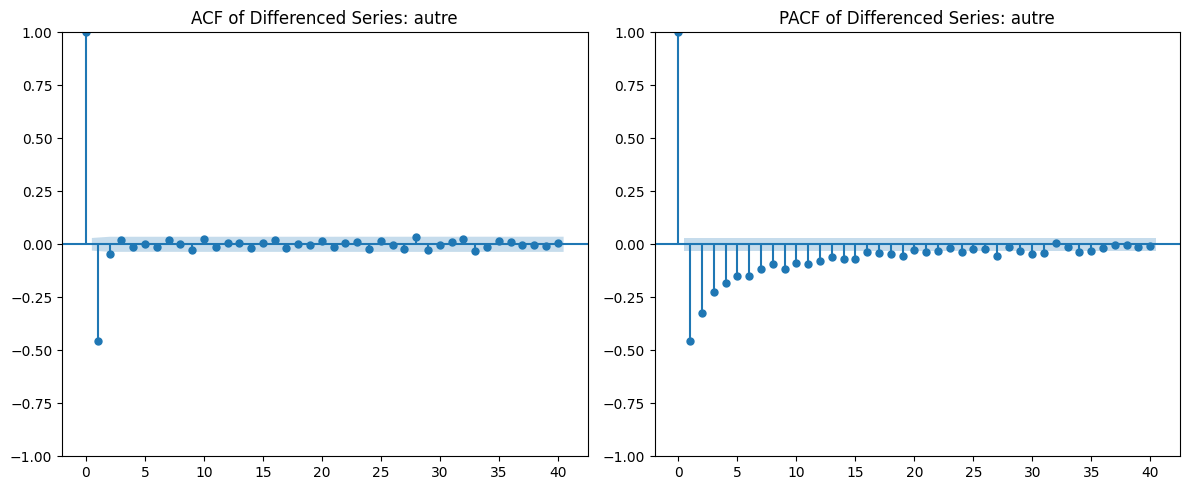

In [10]:
for key, ts in ts_diff_dict.items():
    acf_pcf(ts, key)

From the previous plots it seems that an _ARIMA(0, 1, 1)_ or _ARIMA(0, 1, 2)_ at most would be a great fit.

In [11]:
model_fits = {'admin':{(0, 1, 1): 0, (0, 1, 2): 0},  
              'centre_com': {(0, 1, 1): 0, (0, 1, 2): 0}, 
              'occup_cont': {(0, 1, 1): 0, (0, 1, 2): 0}, 
              'autre': {(0, 1, 1): 0, (0, 1, 2): 0}}

orders = [(0, 1, 1), (0, 1, 2)]
categs = list(ts_dict.keys())

for key, ts in ts_dict.items():
    for order in orders:
        model = ARIMA(ts, order=order)
        model_fit = model.fit()
        model_fits[key][order] = model_fit

In [12]:
columns = pd.MultiIndex.from_tuples([(cat, str(order)) for cat in categs for order in orders])

comparison_admin = pd.DataFrame(
    data=[[model_fits[cat][order].aic for cat in categs for order in orders], 
          [model_fits[cat][order].bic for cat in categs for order in orders]], 
    columns=columns, 
    index=['AIC', 'BIC']
    )

comparison_admin

admin                  centre_com                  occup_cont  \
        (0, 1, 1)     (0, 1, 2)     (0, 1, 1)     (0, 1, 2)     (0, 1, 1)   
AIC  23492.781390  23469.833438  25165.525457  24824.424485  26292.720513   
BIC  23505.548256  23488.983738  25178.249341  24843.510311  26305.437845   

                          autre                
        (0, 1, 2)     (0, 1, 1)     (0, 1, 2)  
AIC  25943.460833  24069.620899  24041.075534  
BIC  25962.536832  24082.352709  24060.173249

It seems like an _ARIMA(0, 1, 2)_ is a better fit.

**Residual analysis**

In [13]:
def analyse_residuals(ts, params: tuple):
    model = ARIMA(ts, order=params)
    model_fit = model.fit()
    residuals = pd.DataFrame(model_fit.resid)
    
    fig, axs = plt.subplots(1, 2, figsize = (18, 6))
    
    axs[0].plot(residuals)
    axs[0].set_title('Time plot of residuals')
    
    sns.histplot(residuals, ax=axs[1], kde=True)
    axs[1].set_title('Density plot of residuals')
    
    fig.suptitle('Residual analysis')
    plt.show()
    
    print(f'--> Summary: {residuals.describe()}')
    

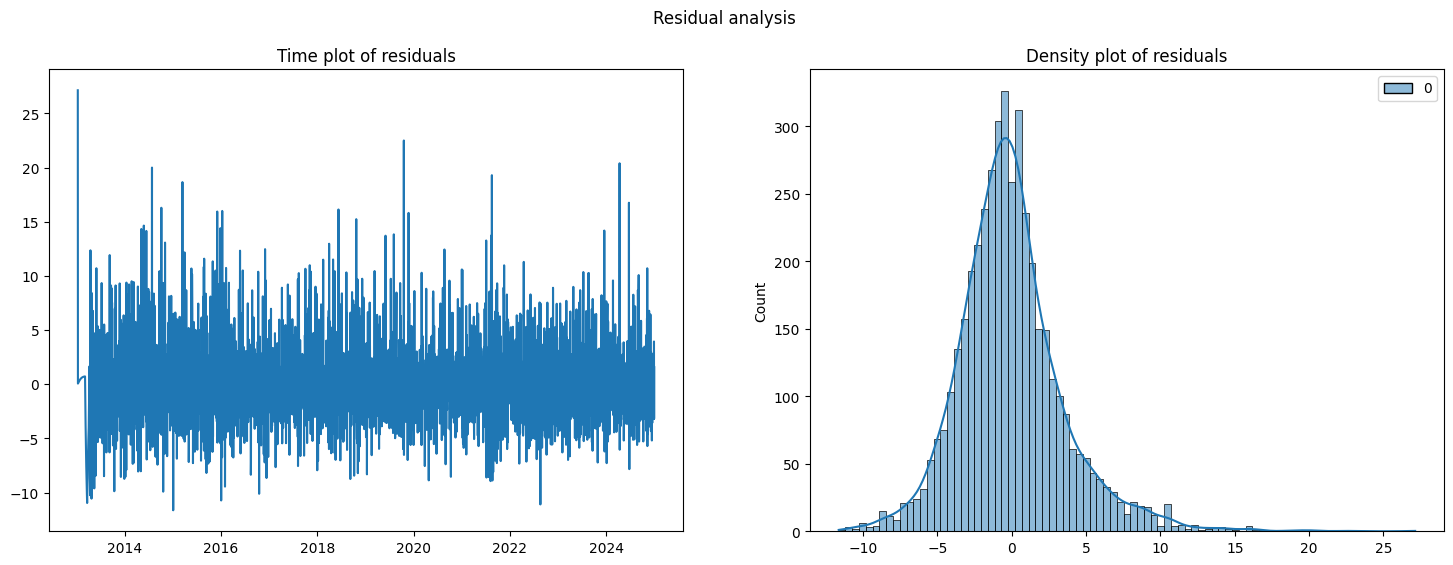

--> Summary:                  0
count  4375.000000
mean     -0.046624
std       3.559571
min     -11.637649
25%      -2.176558
50%      -0.369851
75%       1.569203
max      27.130000


In [14]:
analyse_residuals(ts_admin, (0, 1, 2))

The mean of the residuals is very close to 0, which is in favor of the robustness of our model.

**Prediction and validation**

Before predicting let's define a function that splits our data into a train time series and test time series.

In [15]:
def split(ts):
    ts_train, ts_test = train_test_split(ts, test_size = 0.01, shuffle=False)
    return ts_train, ts_test

Now let's apply our model to predict ts_admin values.

In [16]:
ts_admin_train, ts_admin_test = split(ts_admin)

In [17]:
ts_admin_train

date_etablissement_dpe
2013-01-09    27.130000
2013-01-10    27.186000
2013-01-11    27.242000
2013-01-12    27.298000
2013-01-13    27.354000
                ...    
2024-11-13    12.028250
2024-11-14     8.176576
2024-11-15    11.414107
2024-11-16    15.225470
2024-11-17    11.116728
Freq: D, Length: 4331, dtype: float64

In [18]:
ts_admin_test

date_etablissement_dpe
2024-11-18     8.814824
2024-11-19    15.819041
2024-11-20    10.593910
2024-11-21    11.236928
2024-11-22    17.700764
2024-11-23    16.343032
2024-11-24    13.114112
2024-11-25    14.046361
2024-11-26     8.227749
2024-11-27    13.661667
2024-11-28    12.378421
2024-11-29     8.982978
2024-11-30     9.179443
2024-12-01    11.265303
2024-12-02    17.921052
2024-12-03    10.106239
2024-12-04    11.832838
2024-12-05     8.748264
2024-12-06     7.011437
2024-12-07    13.900056
2024-12-08    10.006678
2024-12-09     9.758730
2024-12-10     9.806540
2024-12-11     8.326801
2024-12-12     9.020895
2024-12-13     5.482020
2024-12-14    10.428289
2024-12-15     8.572508
2024-12-16     6.591489
2024-12-17    11.257354
2024-12-18    10.508798
2024-12-19    10.869021
2024-12-20     8.390623
2024-12-21    10.187001
2024-12-22     9.256928
2024-12-23     7.783811
2024-12-24    12.518730
2024-12-25     8.844685
2024-12-26    11.678293
2024-12-27    10.712296
2024-12-28     6.

In [19]:
history = list(ts_admin_train)
ts_admin_predicted = []
for i in range(len(ts_admin_test)):
    model = ARIMA(history, order=(0, 1, 2))
    model_fit = model.fit()
    yhat = model_fit.forecast()[0]
    ts_admin_predicted.append(yhat)
    y = ts_admin_test.iloc[i]
    history.append(y)
    print(f'Run {i}/{len(ts_admin_test)} -- Predicted: {yhat: 02.2f} / Observed: {y: 02.2f}')

Run 0/44 -- Predicted:  10.65 / Observed:  8.81
Run 1/44 -- Predicted:  10.36 / Observed:  15.82
Run 2/44 -- Predicted:  11.33 / Observed:  10.59
Run 3/44 -- Predicted:  10.80 / Observed:  11.24
Run 4/44 -- Predicted:  10.92 / Observed:  17.70
Run 5/44 -- Predicted:  11.91 / Observed:  16.34
Run 6/44 -- Predicted:  12.07 / Observed:  13.11
Run 7/44 -- Predicted:  11.89 / Observed:  14.05
Run 8/44 -- Predicted:  12.14 / Observed:  8.23
Run 9/44 -- Predicted:  11.38 / Observed:  13.66
Run 10/44 -- Predicted:  12.02 / Observed:  12.38
Run 11/44 -- Predicted:  11.90 / Observed:  8.98
Run 12/44 -- Predicted:  11.43 / Observed:  9.18
Run 13/44 -- Predicted:  11.31 / Observed:  11.27
Run 14/44 -- Predicted:  11.48 / Observed:  17.92
Run 15/44 -- Predicted:  12.46 / Observed:  10.11
Run 16/44 -- Predicted:  11.61 / Observed:  11.83
Run 17/44 -- Predicted:  11.82 / Observed:  8.75
Run 18/44 -- Predicted:  11.34 / Observed:  7.01
Run 19/44 -- Predicted:  10.92 / Observed:  13.90
Run 20/44 -- Pre

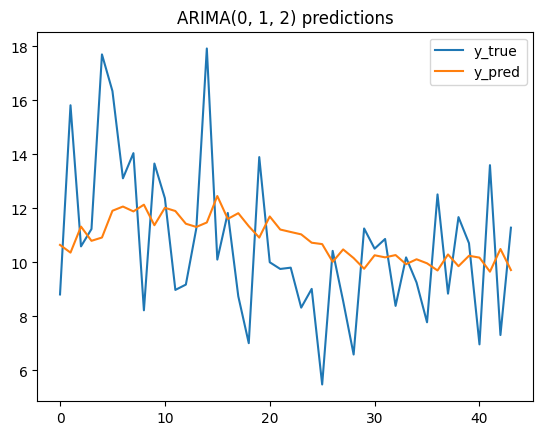

In [20]:
n = len(ts_admin_test)
plt.plot(range(n), ts_admin_test, label='y_true')
plt.plot(range(n), ts_admin_predicted, label='y_pred')
plt.legend()
plt.title('ARIMA(0, 1, 2) predictions')
plt.show()

In [21]:
rmse = mean_squared_error(y_true=ts_admin_test, y_pred=ts_admin_predicted)
print(f'RMSE: {rmse}')

RMSE: 7.91084538499231


These _mediocre_ results were expected for a simple model like ARIMA.